# EXAFS Analysis
This example covers:
1. Read processed data
3. LCF of standard to experimental data
4. Saving processed data

Reading is shown using processed data in previous notebook. The data comes from Athena files

After reading the data is presented as a plot.

XANES is performed by plotting the standards and the data together to enable comparison.


## Resources
Pyhon modules and libraries used in this example

In [1]:
# code for importing custom helper libraries
import sys
# moved all custom helper libraries to a level bellow this directory.
sys.path.append('../lib/')

# Library with the functions that provide the larch functionalities
# equivalent to those provided by athena including normalisation, 
# merging, re-binning, LCF and visualisation (plotting)
import manage_athena as athenamgr 

# additional custom plot functions (replicate plots in published papers)
import custom_plots

# File handling
from pathlib import Path

# Handling json files
import json

# printing formated json data
import pprint

# to copy the mutable types like dictionaries, use copy/deepcopy 
import copy

#plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 

# 1. Read data

The process is divided in two steps. The first step entails reading the metadata which indicates the location of the data and some additional parameters such as  group names and file mappings. The second step uses this metadata to retrieve the experimental results from the files indicated in the metadata.

## Data mappings
Variables used for mapping processed data to results in paper. In this case these data are for figure 4A. The mappings are stored in a json file which was produced in the previous step named "PtSn_KEdge_XANES.json".


In [2]:
json_file = "../outputs/PtSn_KEdge/PtSn_KEdge_LCF.json"
json_metadata = {}

with open(json_file) as json_data:
    json_metadata = json.load(json_data)

pprint.pprint(json_metadata)

{'data_file': 'Xray_data.zip',
 'data_mapping': {'data_path': '../outputs/PtSn_KEdge',
                  'data_type': 'athena',
                  'file_mappings': [{'file_name': 'PtSn_KEdge_LCF.prj',
                                     'group': 'PtSn',
                                     'group_name': 'PtSn'},
                                    {'file_name': 'PtSn_KEdge_LCF.prj',
                                     'group': 'Air',
                                     'group_name': 'Air'},
                                    {'file_name': 'PtSn_KEdge_LCF.prj',
                                     'group': 'Ar',
                                     'group_name': 'Ar'},
                                    {'file_name': 'PtSn_KEdge_LCF.prj',
                                     'group': 'H2',
                                     'group_name': 'H2'},
                                    {'file_name': 'PtSn_KEdge_LCF.prj',
                                     'group': 'PtSn H',
          

## 1 Read processed data

The process below reads the data from the output file generated in the previous step and collects the groups in a dictionary for further processing and analysis

In [3]:
snkedge_data={}

# read all samples, merge and then normalise
project_path = Path(json_metadata["data_mapping"]["data_path"])

for a_mapping in json_metadata["data_mapping"]["file_mappings"]:
    # project file name
    project_name = a_mapping['file_name']
    # name assigned to the readings for processing and display
    data_group =  a_mapping['group']    
    # the group names use underscores instead of spaces and periods 
    # in athena file
    group_name =  a_mapping['group_name']
    # read each group from the corresponding project file
    athena_project = athenamgr.read_project(Path(project_path,project_name))

    snkedge_data[data_group] = athenamgr.get_group(athena_project, group_name)


Just to check we plot the data collected so far 

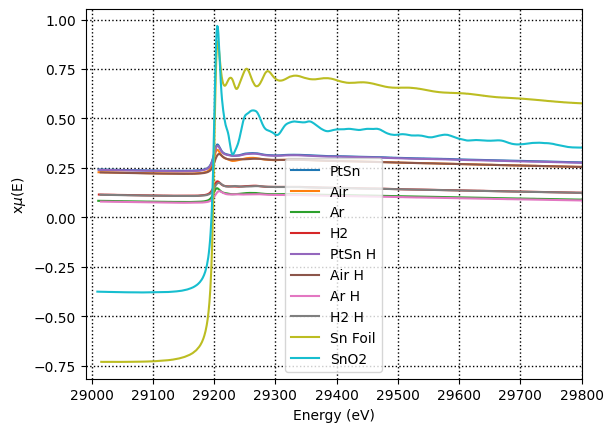

In [4]:
for a_group in snkedge_data:
   plt = athenamgr.plot_mu(snkedge_data[a_group])

plt.title("")
plt.xlim([28990, 29800])
plt.show()

# 2. Rebin data
Rebin is required for XAS processing (see [Athena Manual](https://bruceravel.github.io/demeter/documents/Athena/process/rebin.html). So, the next cell rebins the metadata that needs to be analysed (H2, Ar, and Air).

In [5]:
out_prefix = "PtSn_KEdge"
out_path = Path("../outputs",out_prefix)
# Rebin Ar, Air and H2 Samples 
rebin_labels = ["H2", "Ar", "Air"]
rebinned_groups = {}
rebinned_gr=None
for a_sample in snkedge_data:
    if a_sample in rebin_labels:
        rebinned_gr = athenamgr.rebin_group(snkedge_data[a_sample])
        rebinned_gr.arrayname = a_sample+" Rebbined"
        rebinned_groups[a_sample+" Rebbined"] = rebinned_gr
        print(a_sample, "rebinned to" , len(rebinned_gr.energy),"from", len(snkedge_data["Ar"].energy))
rebin_project = Path(out_path, "rebinned.prj")
athenamgr.save_groups([rebinned_groups["H2 Rebbined"],rebinned_groups["Ar Rebbined"],rebinned_groups["Air Rebbined"]], rebin_project)

print("*"*80)
print("Rebinned data saved to:",str(rebin_project))

# read the rebinned data from the project 
athena_prj = athenamgr.read_project(rebin_project)

fit_groups = athenamgr.get_groups(athena_prj)


group_names = []
for a_group in fit_groups:
    group_names.append(a_group.label)
 
# recalculate and normalise signals
for a_group in fit_groups:
    athenamgr.calc_with_defaults(a_group)    

Air rebinned to 378 from 2093
Ar rebinned to 378 from 2093
H2 rebinned to 378 from 2093
********************************************************************************
Rebinned data saved to: ..\outputs\PtSn_KEdge\rebinned.prj


# 3. Read crystal data
The required crystal data and the fitting parameters to perform the EXAFS analysis.


In [6]:
exafs_file = "./figure_5_exafs.json"
exafs_metadata = {}

with open(exafs_file) as json_data:
    exafs_metadata = json.load(json_data)

pprint.pprint(exafs_metadata)

{'data_file': 'Xray_data.zip',
 'data_object': {'cdi_do': 537, 'doi': '10.5258/SOTON/D0408'},
 'figure_id': 'Figure 5',
 'publication': {'cdi_pub': 37, 'doi': '10.1039/c7fd00221a'},
 'variables': {'xafs_analyses': {'absorbing_atoms': ['Sn', 'Sn', 'O', 'Pt'],
                                 'crystal_files': ['1690711.cif',
                                                   '1692396.cif',
                                                   '1680385.cif',
                                                   '1692395b.cif'],
                                 'data_path': '../wf_data/pub_037/additional',
                                 'fit_vars': {'dk': 1,
                                              'fitspace': 'r',
                                              'kmax': 10,
                                              'kmin': 0,
                                              'kw': 2,
                                              'rmax': 5.0,
                                              'rm

In [7]:
# Fitting input variables
# All crystals for this fit are stored at: 
#    C:/harwell/PSDI_test/wf_data/pub_037/additional/
#       1692395a.cif  Pt3Sn for Sn
#       1690711.cif   SnO2
#       1680385.cif   PtO2
#       1692395b.cif  Pt3Sn for Pt
# new test replace Pt3Sn (1692395a.cif) with PtSn
#       1692396.cif   PtSn for Sn 

# we know we are reading data for EXAFS and
# that variables hold the required values
data_path = Path(exafs_metadata["variables"]['xafs_analyses']["data_path"])
crystal_files = []
for a_file in exafs_metadata["variables"]['xafs_analyses']["crystal_files"]:
    crystal_files.append(str(Path(data_path, a_file)))
    
print(crystal_files)

# paths and parameters are saved as csv files 
# and they can be retrieved (after calculations of FEFF paths)
sel_paths_f = exafs_metadata["variables"]['xafs_analyses']["selected_paths"]  
gds_parms_f = exafs_metadata["variables"]['xafs_analyses']["gds_parameters"] 

# variables for fit
fit_vars = exafs_metadata["variables"]['xafs_analyses']["fit_vars"]


# Need to specify the absorbing atom and maximum radius
absorbing_atoms = exafs_metadata["variables"]['xafs_analyses']["absorbing_atoms"]
max_radius = exafs_metadata["variables"]['xafs_analyses']["max_radius"]

['..\\wf_data\\pub_037\\additional\\1690711.cif', '..\\wf_data\\pub_037\\additional\\1692396.cif', '..\\wf_data\\pub_037\\additional\\1680385.cif', '..\\wf_data\\pub_037\\additional\\1692395b.cif']


# Save athena project

In [8]:
# Library with the functions that execute 
# Atoms and FEFF to generate scattering paths
import atoms_feff as feff_runner     

# Set parameters          
# library containign functions tho manage fit, at read, write 
# GDS parameters, and scattering paths. 
import manage_fit as fit_manager  

from larch import Interpreter
session = Interpreter()

# run feff and get a list of feff dirs
feff_dirs = feff_runner.run_feff(crystal_files, absorbing_atoms, max_radius) 

# could prevent running if the files still exist and they are recent (<month old)


No conda env active, defaulting to base
Processing: ..\wf_data\pub_037\additional\1690711.cif
check if need to build: 1690711_feff
 : ======== running Feff module C:\Users\scman1\AppData\Local\Programs\Python\Python39\lib\site-packages\larch\bin\win64\feff6l.exe ========
 : Feff 6L.02
 : Formula:    SnO2
 : SpaceGroup: P4_2/mnm
 : # sites:    6
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : Preparing plane wave scattering amplitudes...
 : nncrit in prcrit       9
 : Searching f

 : 10     8.981     8.000     2   4.8586
 : 11    22.270    16.000     2   4.8586
 : 5 paths kept,   11 examined.
 : Feff done.  Have a nice day.


In [9]:
# read saved parameters from input gds file
gds = fit_manager.read_gds(gds_parms_f, session)
# show gsd group parameters in a spreadsheet
this_sheet = fit_manager.show_gds(gds)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_parms_f)

Sheet(cells=(Cell(column_start=0, row_end=19, row_start=0, squeeze_column=False, squeeze_row=False, value=[['i…

In [10]:
# just in case something was changed
# read the gds data and save it to the csv file 
gds = fit_manager.spreadsheet_to_gds(this_sheet, session)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_parms_f)

In [11]:
# read saved selected paths from input file
selected_paths = fit_manager.read_selected_paths_list(sel_paths_f, session)

path_sheet = fit_manager.show_feff_paths(crystal_files, selected_paths)
display(path_sheet)

Sheet(cells=(Cell(column_end=7, column_start=0, row_end=50, row_start=0, squeeze_column=False, squeeze_row=Fal…

In [12]:
sp_sheet = fit_manager.show_selected_paths(path_sheet, selected_paths)

Sheet(cells=(Cell(column_end=5, column_start=0, row_start=0, squeeze_column=False, squeeze_row=False, type='te…

In [13]:
fit_manager.save_selected_paths_list(sp_sheet, sel_paths_f)
selected_paths = fit_manager.read_selected_paths_list(sel_paths_f, session)

In [14]:
# run fit
fit_list = {}
for a_group in fit_groups:
    trans, dset, out = fit_manager.run_fit(a_group, gds, selected_paths, fit_vars, session)
    fit_list[a_group.filename]=[trans, dset, out]

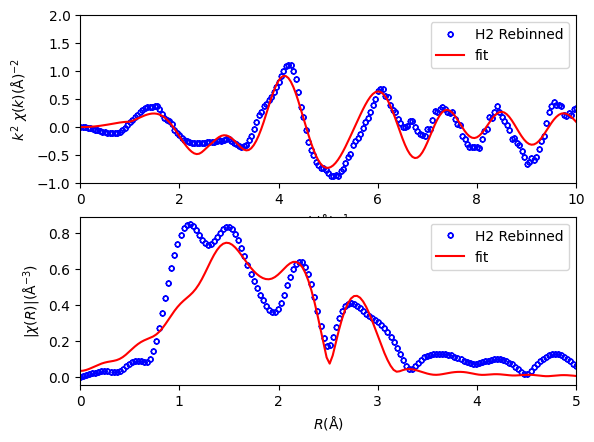

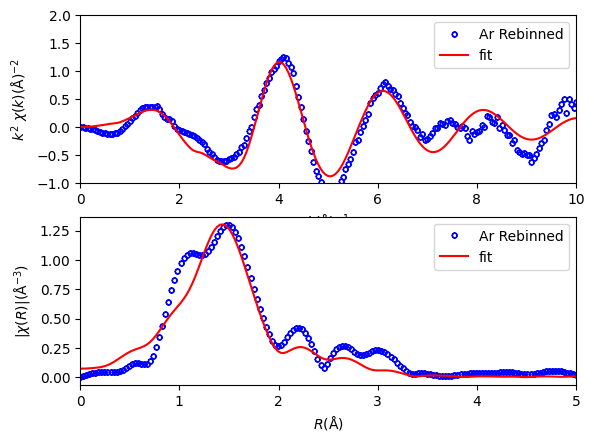

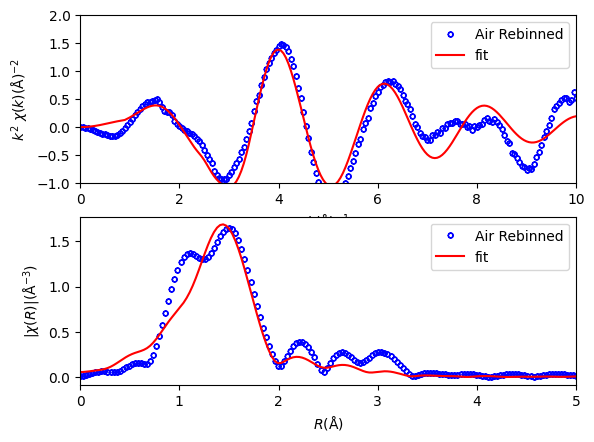

In [15]:
for a_fit in fit_list:
    chikr_p = custom_plots.plot_markers(fit_list[a_fit][1],fit_vars['rmin'],fit_vars['rmax'],fit_vars['kmin'],fit_vars['kmax'], a_fit)
    chikr_p.show()

In [16]:
for a_fit in fit_list:
    print("R-factor %.2f"%(fit_list[a_fit][2].rfactor*100)+"%")

R-factor 21.49%
R-factor 15.72%
R-factor 15.32%


In [17]:
for a_fit in fit_list:
    
    fit_report = fit_manager.get_fit_report(fit_list[a_fit][2], session)
    print("*"*30, a_fit, "*"*30)
    print(fit_report)

****************************** H2 Rebinned ******************************
=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  9, 324
   n_independent      =  32.831
   chi_square         =  16090.5028
   reduced chi_square =  675.192415
   r-factor           =  0.21486674
   Akaike info crit   =  221.375224
   Bayesian info crit =  234.797580
 
[[Data]]
   fit space          = 'r'
   r-range            = 0.000, 5.000
   k-range            = 0.000, 10.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['1690711_feff/feff0001.dat', '1692396_feff/feff0001.dat', '1680385_feff/feff0001.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=6.5492e-04, std=1.5375e-04)
   epsilon_r          = 0.00584232
   n_independent      = 32.831
 
[[Variables]]
   alpha          =  0.04110173 +/-unknown   (init=  0.00000000)
   amp            =  1.65689541 +/-unknown   (init=  1.00000000)
   delr           =  0.00000000 +/-unknown 

## References

The data used in this example is part of the supporting data for:

Huang, Haoliang, Nassr, Abu Bakr Ahmed Amine, Celorrio, Verónica, Taylor, S. F. Rebecca, Puthiyapura, Vinod Kumar, Hardacre, Christopher, Brett, Dan J. L., Russell, Andrea E. (2018) Effects of heat treatment atmosphere on the structure and activity of Pt3Sn nanoparticle electrocatalysts: a characterisation case study. Faraday Discussions. V. 208. pp. 555-573. DOI:[10.1039/c7fd00221a](http://doi.org/10.1039/c7fd00221a).

The data used for reproducing the results was published in the Southampton Instituional Repository DOI: [10.5258/SOTON/D0408](https://eprints.soton.ac.uk/421798/), with the name Xray_data.zip - Dataset.